In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [2]:
df = pd.read_csv('avg_salary.csv')

## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Period      76 non-null     float64
 1   Seniority   76 non-null     object 
 2   IT_Exports  76 non-null     float64
 3   CPI         76 non-null     float64
 4   GDP         76 non-null     float64
 5   Salary      76 non-null     float64
dtypes: float64(5), object(1)
memory usage: 3.7+ KB


In [4]:
df.head()

,Period,Seniority,IT_Exports,CPI,GDP,Salary
0,2015.12,Junior,1325.8,145.8,2094.473877,1064.500000
1,2015.12,Lead,1325.8,145.8,2094.473877,2371.555556
2,2015.12,Middle,1325.8,145.8,2094.473877,1655.376812
3,2015.12,Senior,1325.8,145.8,2094.473877,2540.357143
4,2016.06,Junior,1475.2,148.9,2158.461182,909.240000


In [5]:
df.dtypes

Period        float64
Seniority      object
IT_Exports    float64
CPI           float64
GDP           float64
Salary        float64
dtype: object

In [6]:
df.shape

(76, 6)

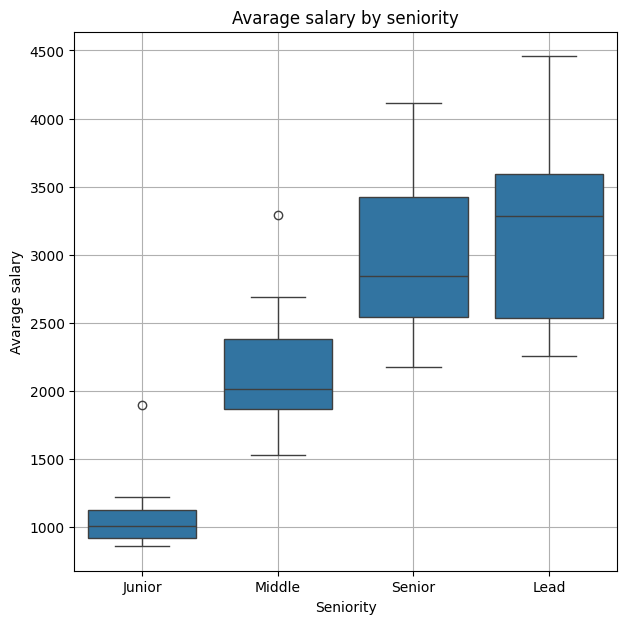

In [7]:
plt.figure(figsize=(7, 7))
sns.boxplot(df, x='Seniority', y = 'Salary', order = df.groupby('Seniority')['Salary'].mean().sort_values().index)
plt.title('Avarage salary by seniority')
plt.ylabel('Avarage salary')
plt.grid()
plt.show()

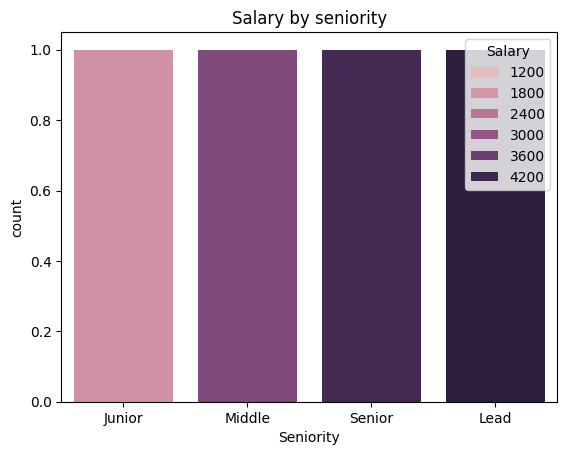

In [8]:
sns.countplot(x = df['Seniority'], hue = df['Salary'], dodge = False, order = df.groupby('Seniority')['Salary'].mean().sort_values().index, saturation = 1.5)
plt.title('Salary by seniority')
plt.show()

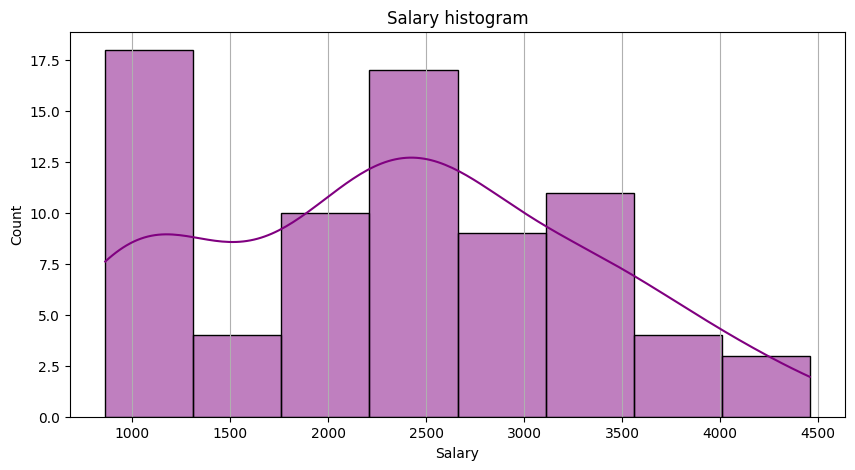

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Salary'], bins = 'auto', kde= True, color = 'purple', edgecolor = 'black')
plt.title('Salary histogram')
plt.grid(axis = 'x')
plt.show()

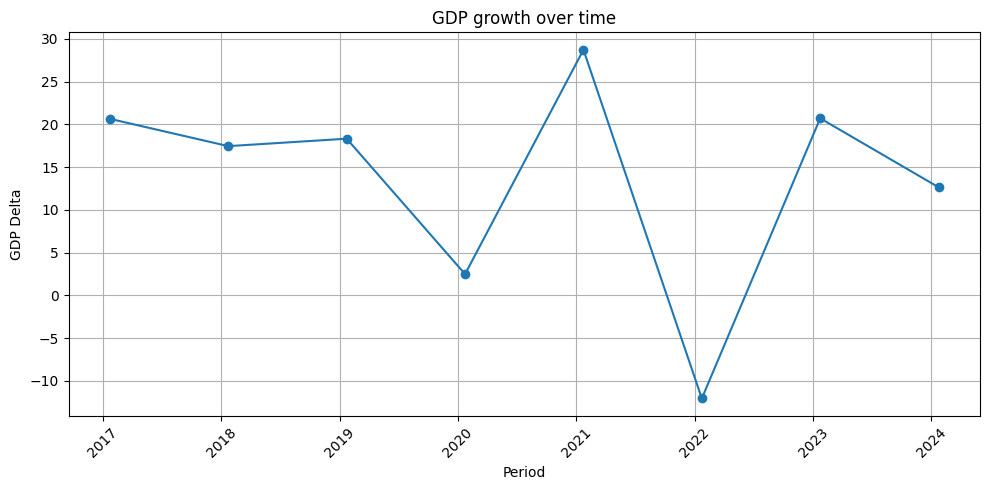

In [10]:
df_gdp = df[['Period', 'GDP']].drop_duplicates().sort_values('Period')
df_gdp = df_gdp[df_gdp['Period'].astype(str).str.endswith('.06')]
df_gdp['GDP Delta%'] = df_gdp['GDP'].pct_change() * 100
plt.figure(figsize=(10, 5))
plt.plot(df_gdp['Period'], df_gdp['GDP Delta%'], marker = 'o', linestyle = '-')
plt.title('GDP growth over time')
plt.xlabel('Period')
plt.ylabel('GDP Delta')
plt.xticks(rotation = 45)
plt.grid()
plt.tight_layout()
plt.show()

### Differentation

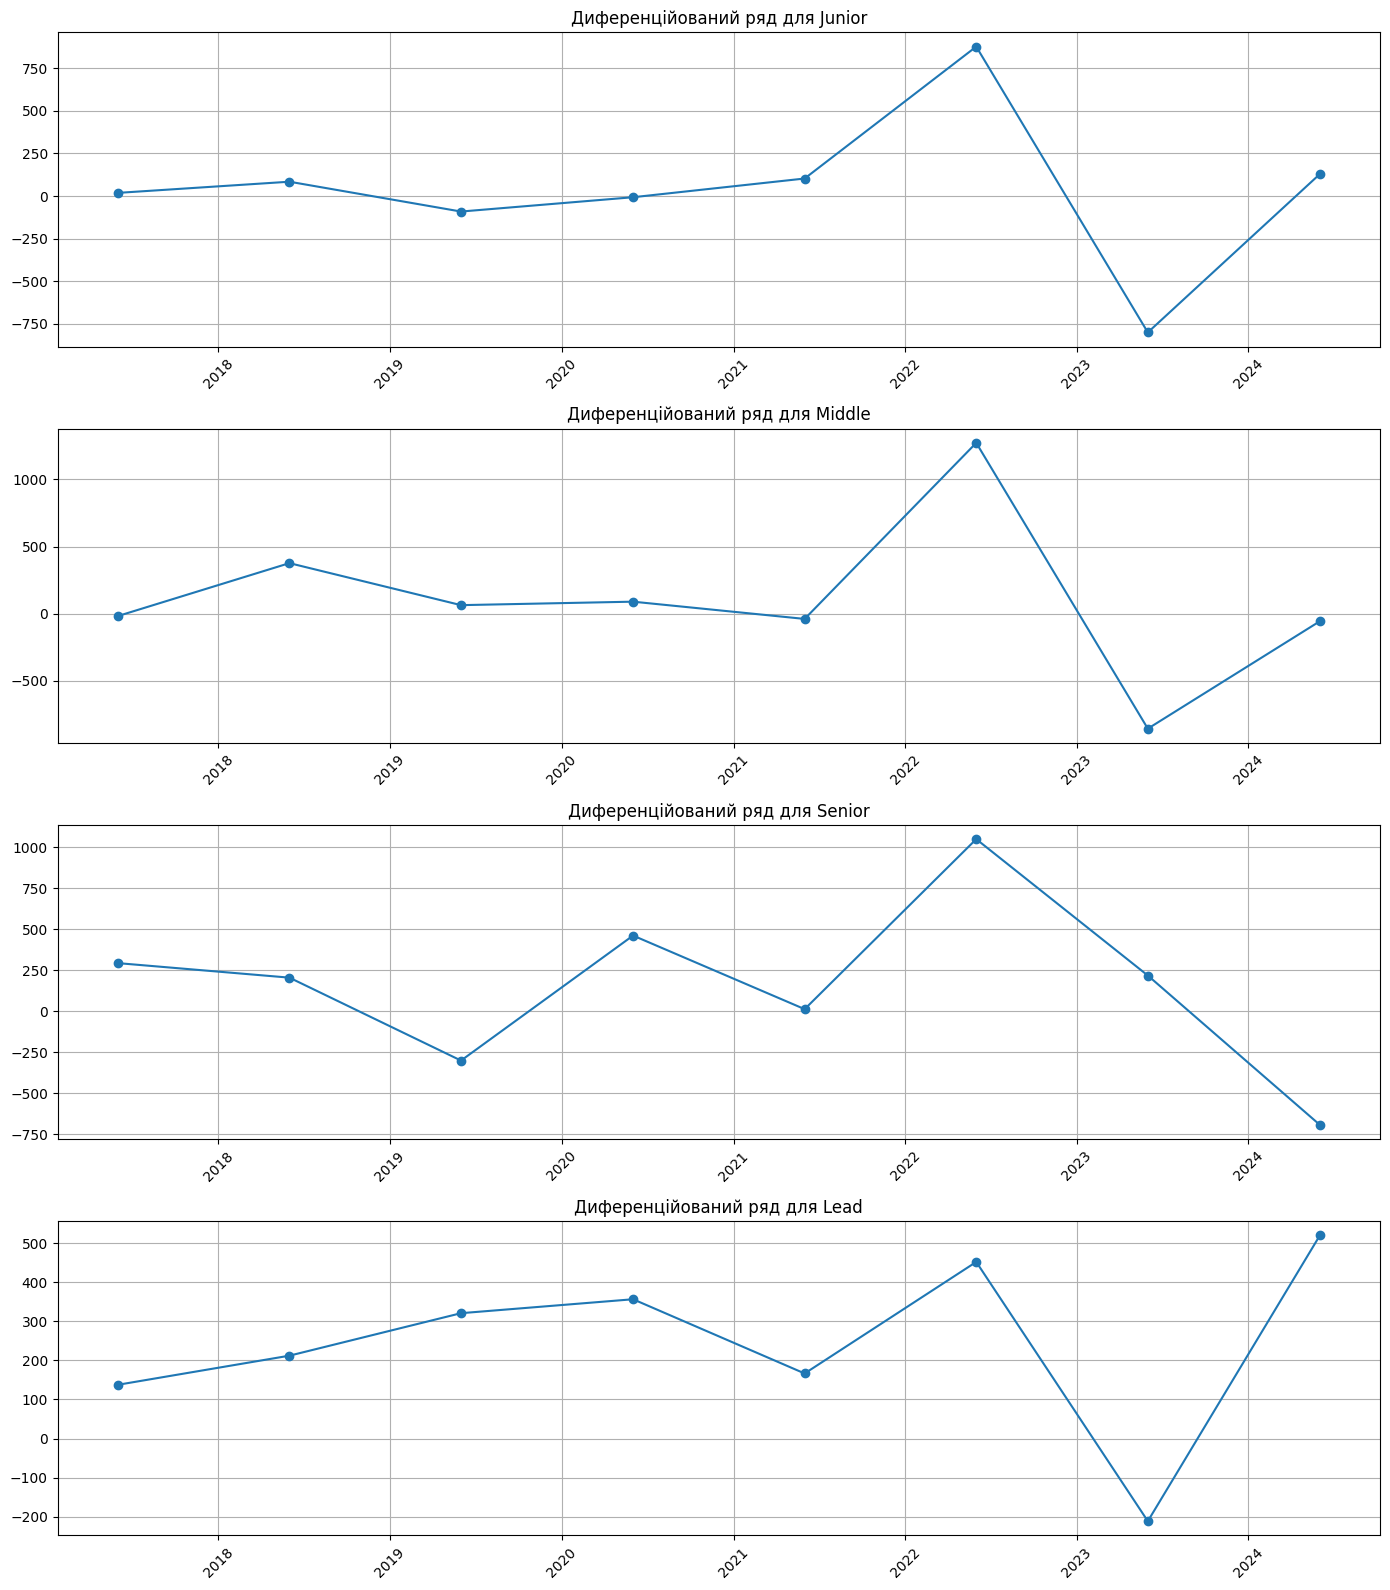

In [11]:
order = ['Junior', 'Middle', 'Senior', 'Lead']
unique_sen = [x for x in order if x in df['Seniority'].unique()]

plt.figure(figsize=(14, 4 * len(unique_sen)))

for i, level in enumerate(unique_sen, start=1):
    subset = df[(df['Seniority'] == level) & ((df['Period'] % 1).round(2) == 0.06)].copy()
    subset['Period_str'] = subset['Period'].apply(lambda x: f"{int(x)}.{int(round((x - int(x)) * 100)):02d}")
    subset['Period_dt'] = pd.to_datetime(subset['Period_str'], format='%Y.%m')
    d_series = subset['Salary'].diff().dropna()
    periods = subset['Period_dt'].iloc[1:]

    plt.subplot(len(unique_sen), 1, i)
    plt.plot(periods, d_series, marker='o')
    plt.title(f'Диференційований ряд для {level}')
    plt.grid()

    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Decomposition

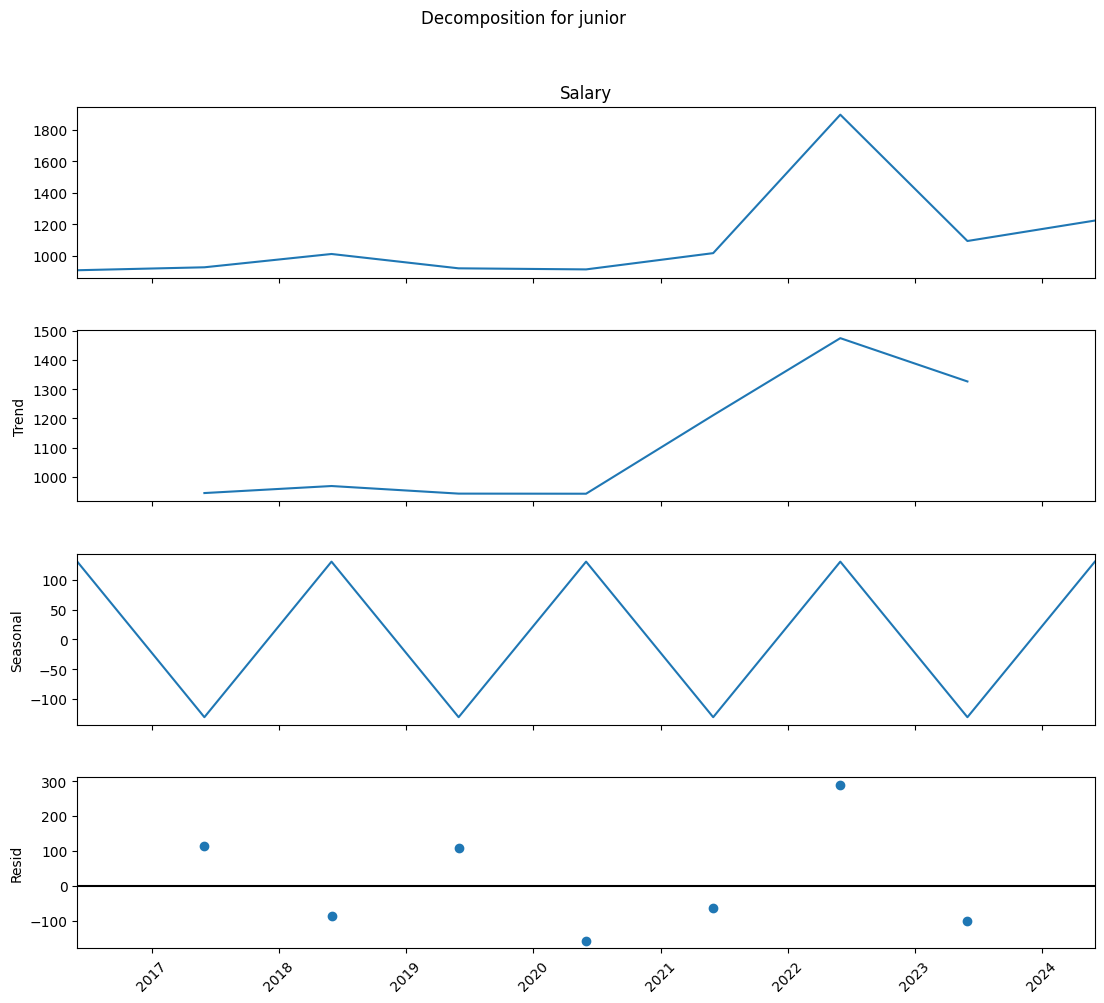

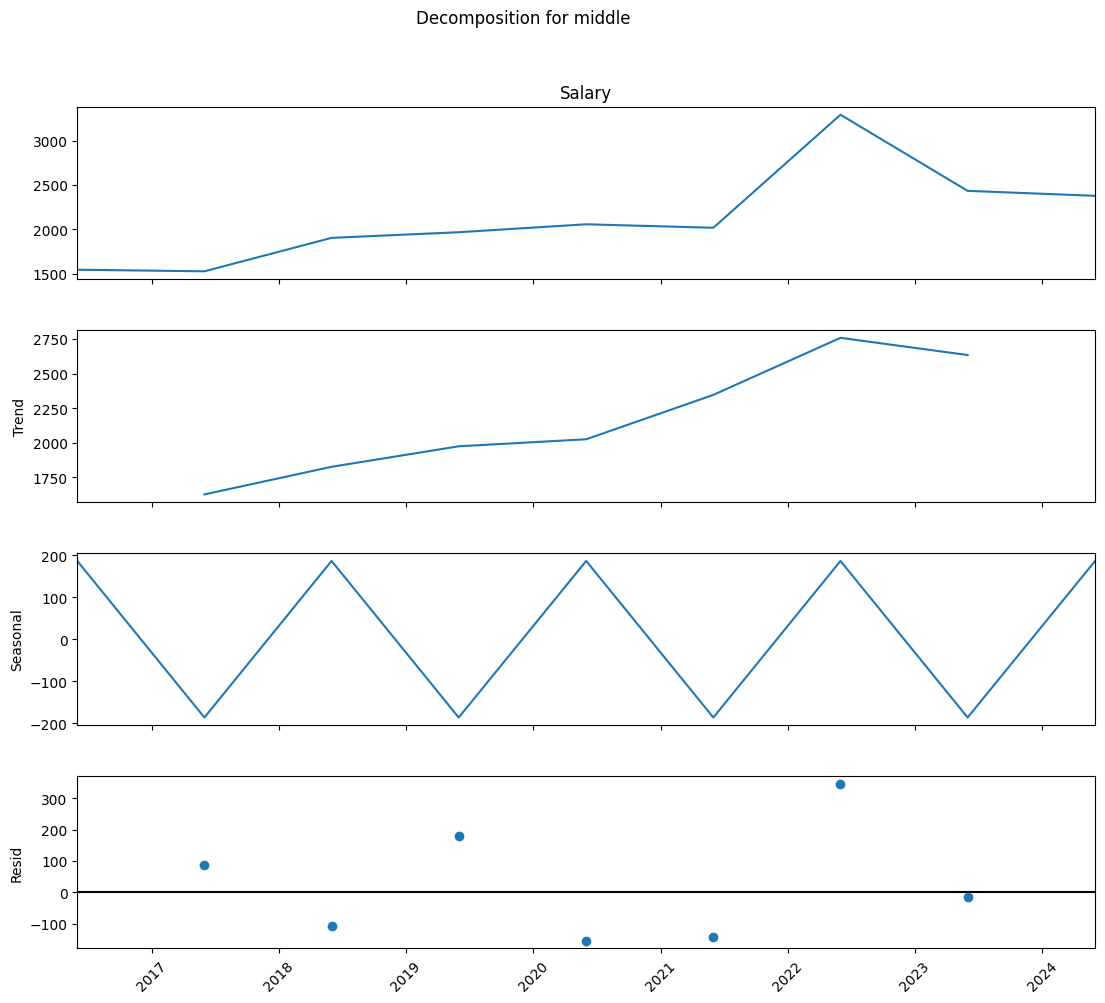

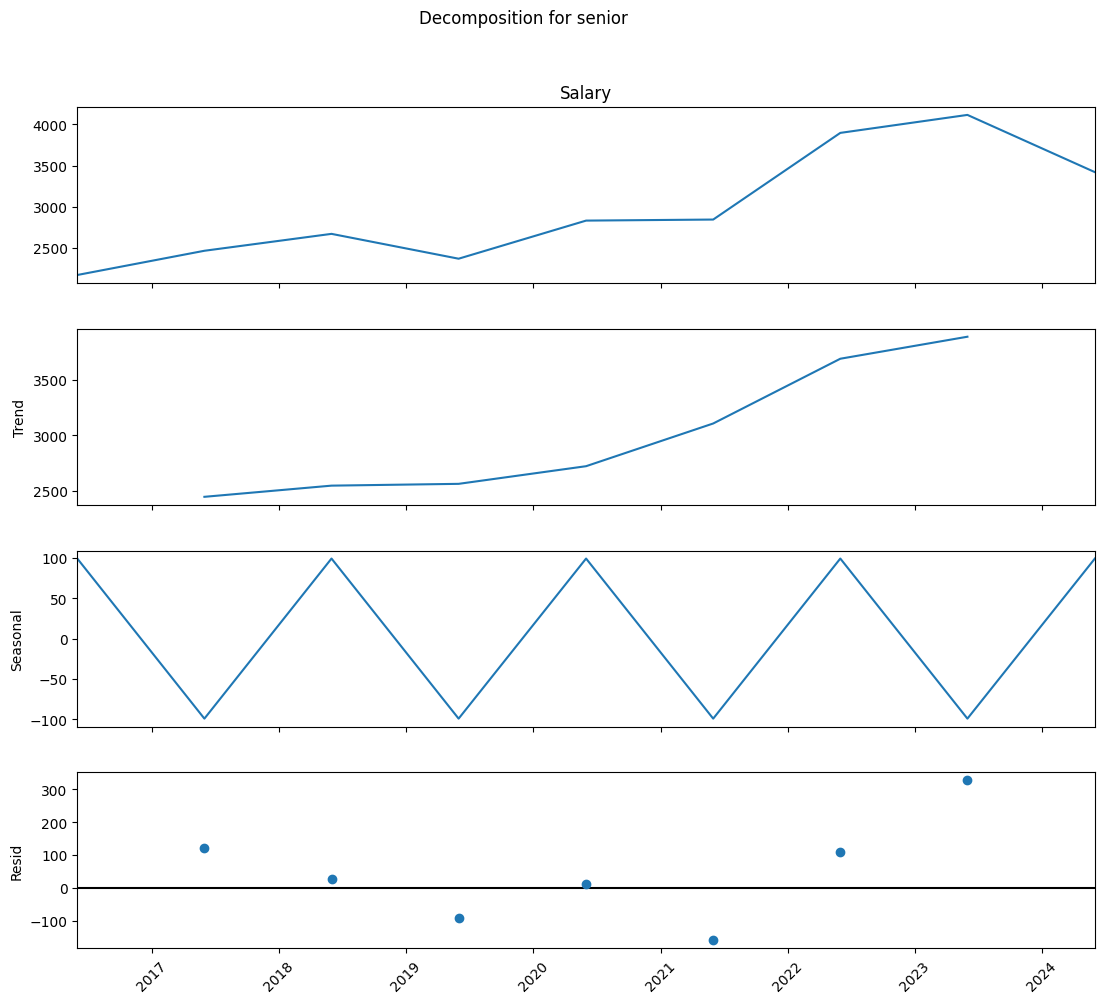

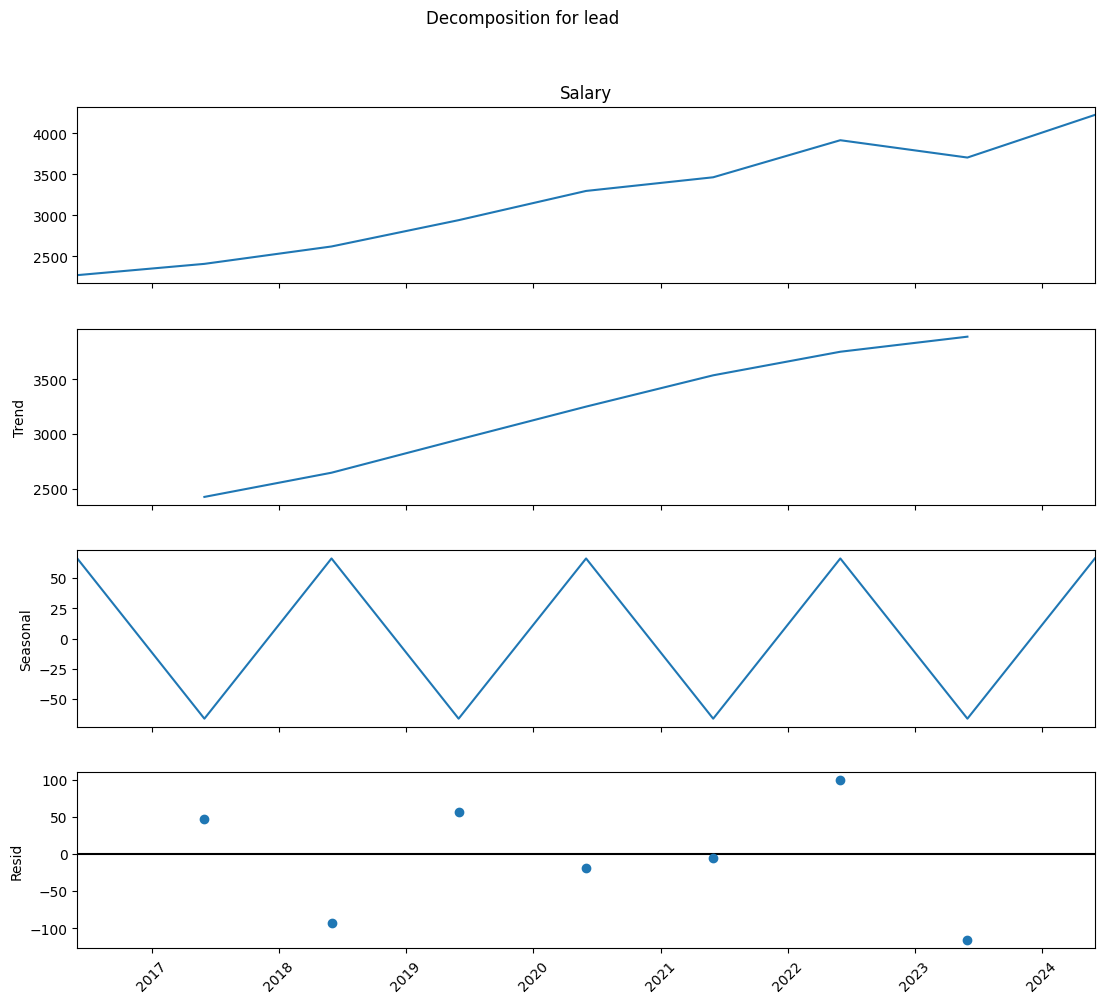

In [12]:
df['Seniority'] = df['Seniority'].str.strip().str.lower()

order = ['junior', 'middle', 'senior', 'lead']
unique_sen = [x for x in order if x in df['Seniority'].unique()]

for level in unique_sen:
    subset = df[(df['Seniority'] == level) & ((df['Period'] % 1).round(2) == 0.06)].copy()
    subset['Period_str'] = subset['Period'].apply(lambda x: f"{int(x)}.{int(round((x - int(x)) * 100)):02d}")
    subset['Period_dt'] = pd.to_datetime(subset['Period_str'], format='%Y.%m')
    subset.set_index('Period_dt', inplace=True)

    s_s = subset['Salary']

    decompose = seasonal_decompose(s_s, model='additive', period=2)

    fig = decompose.plot()
    fig.set_size_inches(12, 10)
    plt.suptitle(f'Decomposition for {level}', y=1.02)
    plt.xticks(rotation=45)
    plt.show()


In [17]:
results = []
df = df.copy()

for l in df['Seniority'].unique():
    subset = df[df['Seniority'] == l].copy()
    stl = STL(subset['Salary'], period = 2)
    res = stl.fit()
    subset['Cleaned'] = res.resid
    results.append(subset)
df_res = pd.concat(results, ignore_index= True)

Insufficient data for Junior level (only 0 points)
Insufficient data for Middle level (only 0 points)
Insufficient data for Senior level (only 0 points)
Insufficient data for Lead level (only 0 points)


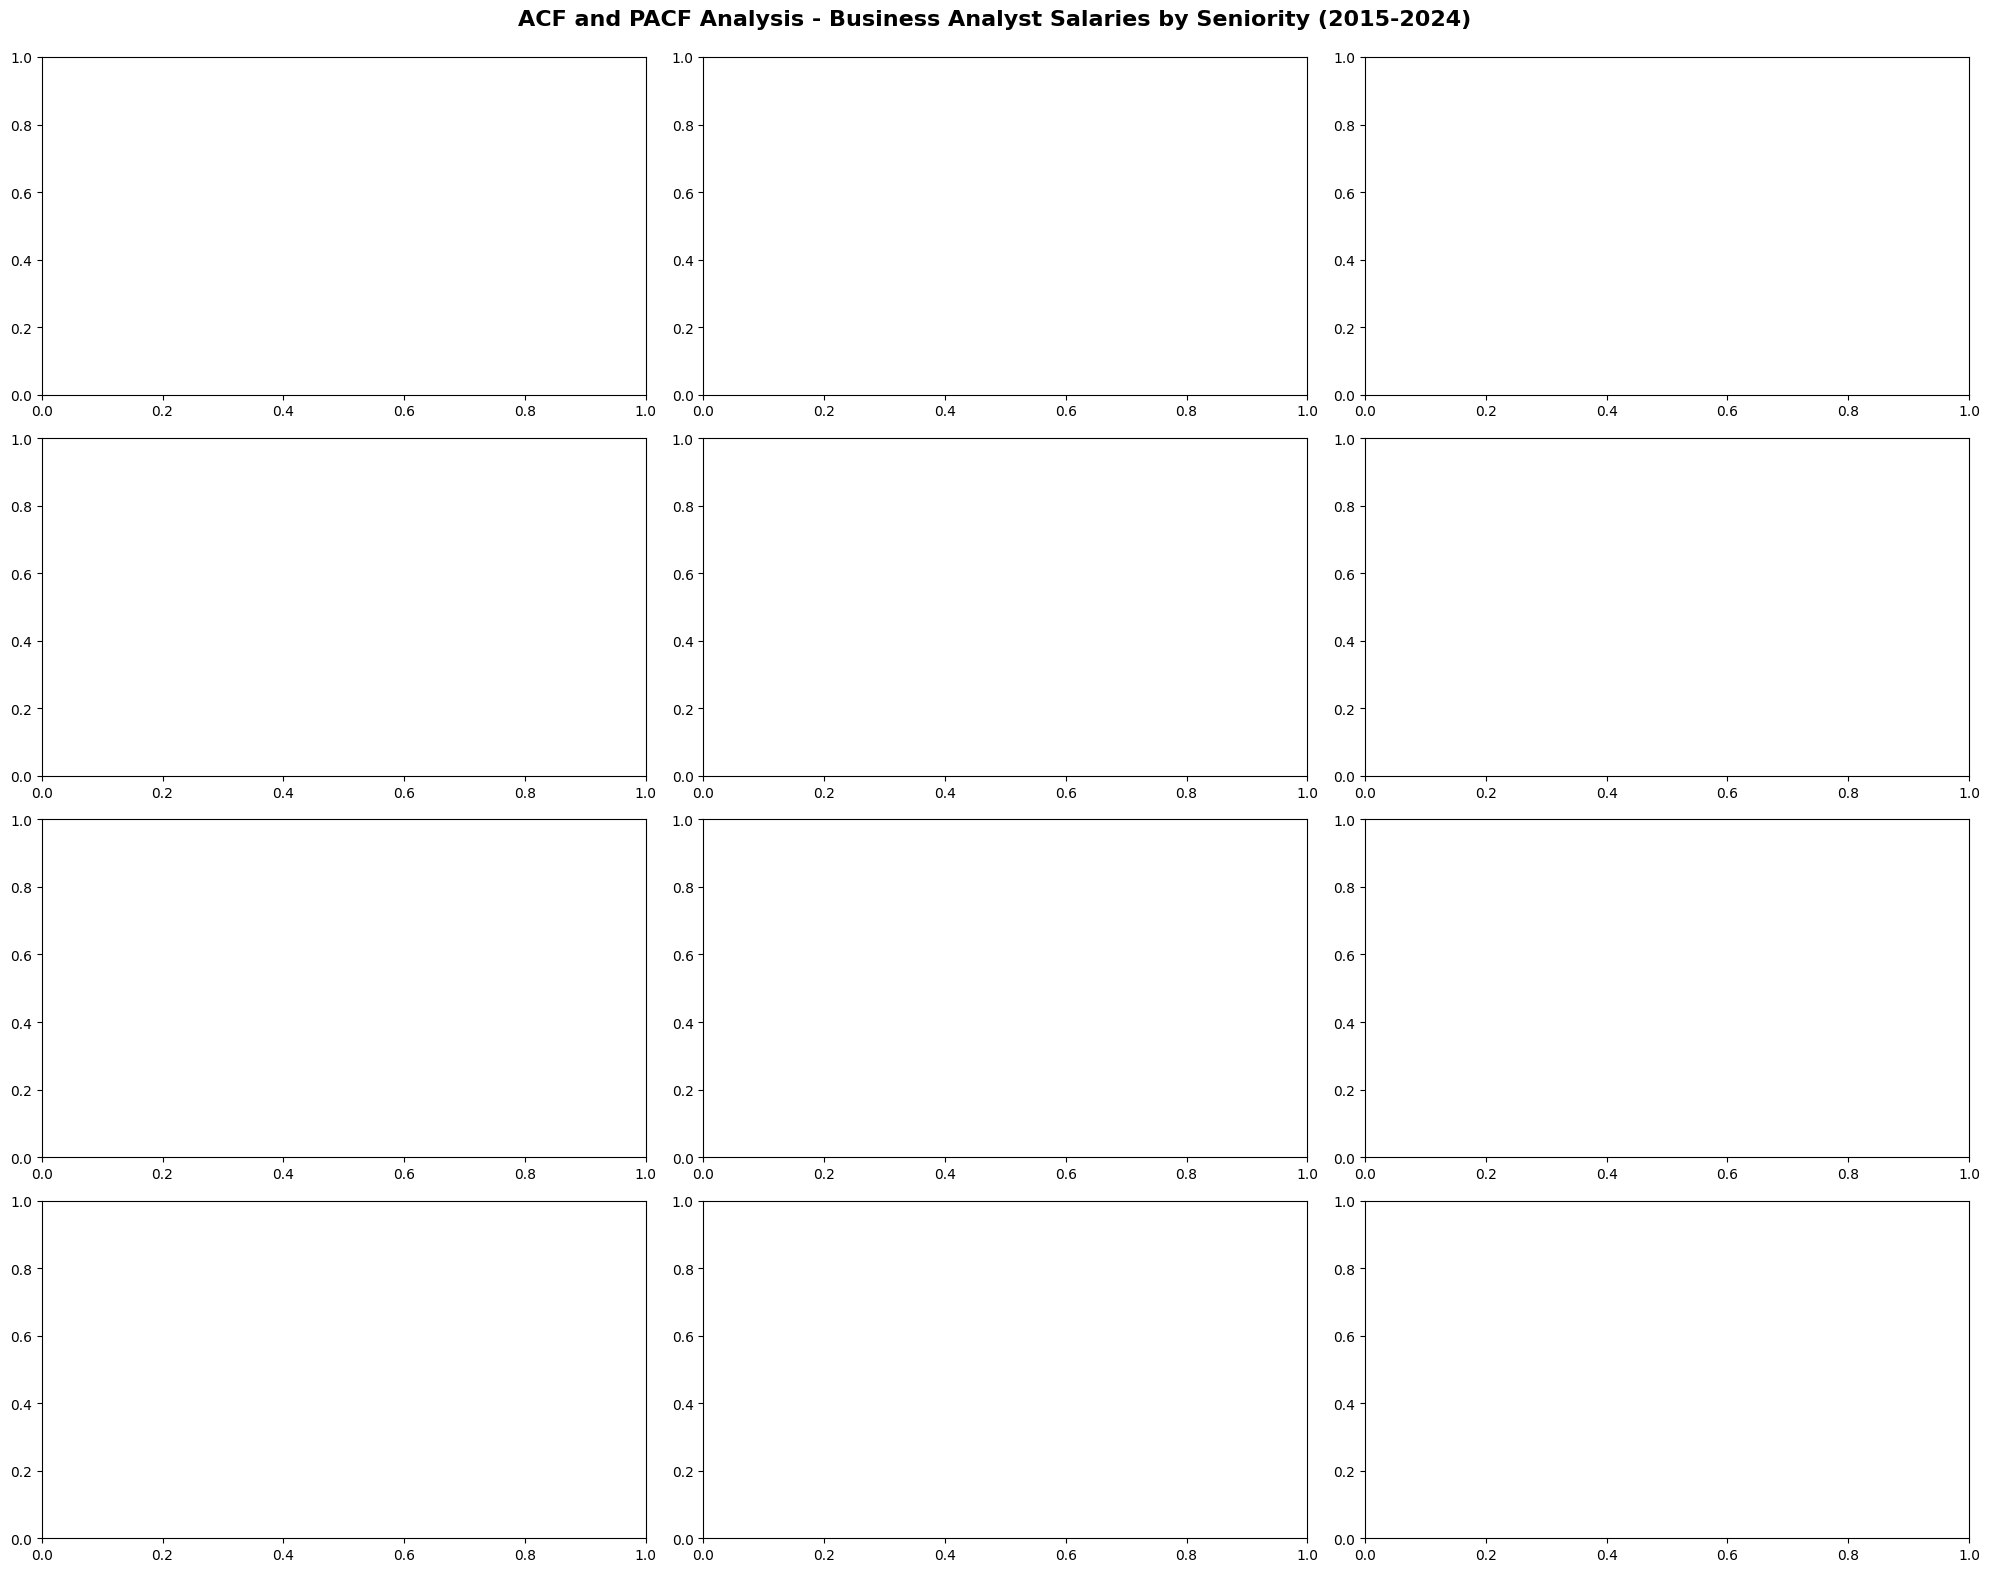


=== Overall Salary Trend Analysis ===


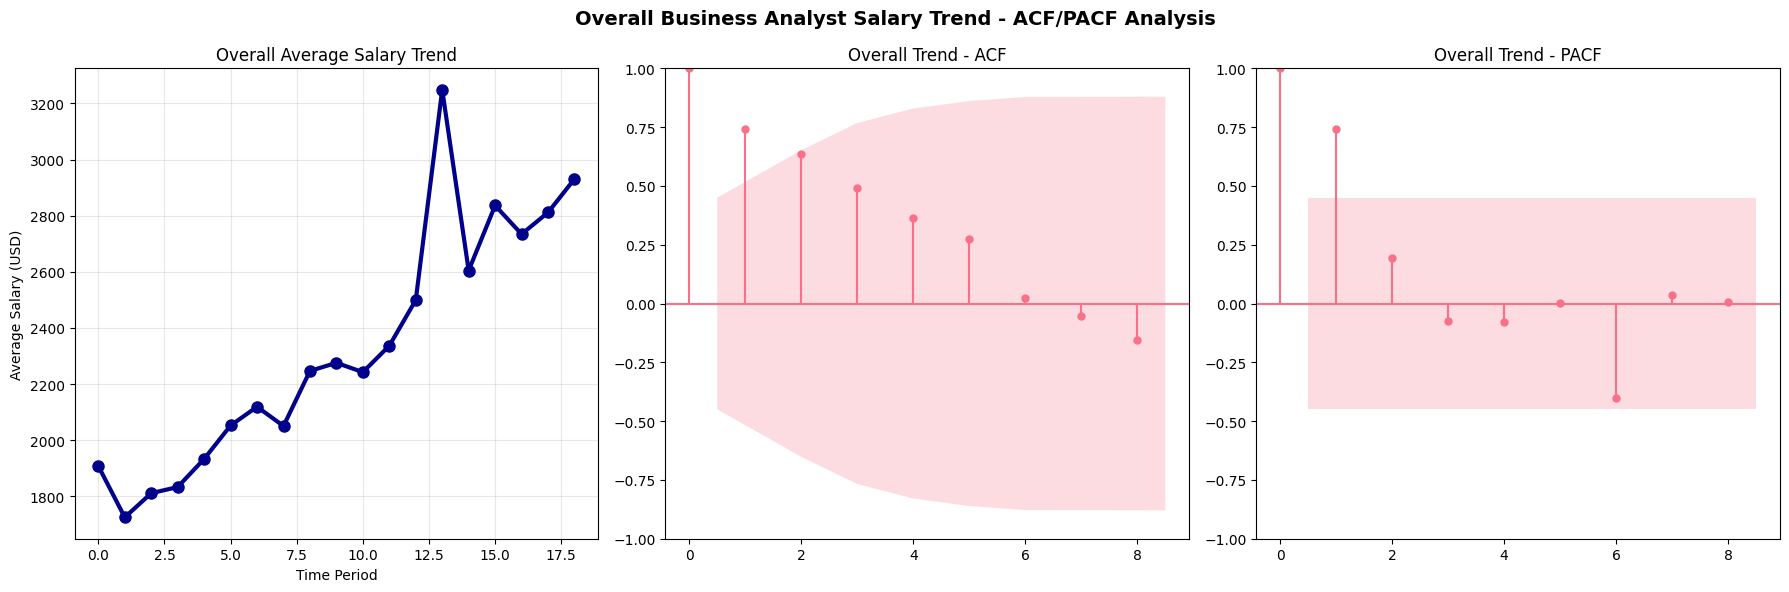

Overall trend statistics:
Data points: 19
Mean salary: $2326


NameError: name 'stats' is not defined

In [ ]:



seniority_levels = ['Junior', 'Middle', 'Senior', 'Lead']


plt.style.use('default')
sns.set_palette("husl")

# Create a comprehensive figure with subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
fig.suptitle('ACF and PACF Analysis - Business Analyst Salaries by Seniority (2015-2024)', 
                fontsize=16, fontweight='bold', y=0.98)

for idx, seniority in enumerate(seniority_levels):
    seniority_data = df[df['Seniority'] == seniority].copy()
    
    if len(seniority_data) < 3:
        print(f"Insufficient data for {seniority} level (only {len(seniority_data)} points)")
        continue
        
    seniority_data = seniority_data.sort_values('Period')
    salary_series = seniority_data['Salary'].values
    
    print(f"\n--- {seniority} Level Analysis ---")
    print(f"Data points: {len(salary_series)}")
    print(f"Salary range: ${salary_series.min():.0f} - ${salary_series.max():.0f}")
    print(f"Mean salary: ${salary_series.mean():.0f}")
    print(f"Std deviation: ${salary_series.std():.0f}")
    
    # Calculate ACF and PACF
    max_lags = min(len(salary_series) // 2, 10)  # Limit lags to half the data length or 10
    
    try:
        acf_values = acf(salary_series, nlags=max_lags, fft=False)
        pacf_values = pacf(salary_series, nlags=max_lags)
        
        axes[idx, 0].plot(range(len(salary_series)), salary_series, marker='o', linewidth=2, markersize=6, label=f'{seniority}')
        axes[idx, 0].set_title(f'{seniority} - Salary Time Series')
        axes[idx, 0].set_xlabel('Time Period')
        axes[idx, 0].set_ylabel('Salary (USD)')
        axes[idx, 0].grid(True, alpha=0.3)
        axes[idx, 0].legend()
        
        plot_acf(salary_series, lags=max_lags, ax=axes[idx, 1], 
                title=f'{seniority} - Autocorrelation Function (ACF)')
        axes[idx, 1].set_xlabel('Lag')
        axes[idx, 1].set_ylabel('ACF')
        
        plot_pacf(salary_series, lags=max_lags, ax=axes[idx, 2], 
                    title=f'{seniority} - Partial Autocorrelation Function (PACF)')
        axes[idx, 2].set_xlabel('Lag')
        axes[idx, 2].set_ylabel('PACF')
        
        significant_acf = [(i, val) for i, val in enumerate(acf_values[1:], 1) 
                            if abs(val) > 0.3]  # Threshold for significance
        significant_pacf = [(i, val) for i, val in enumerate(pacf_values[1:], 1) 
                            if abs(val) > 0.3]
        
        if significant_acf:
            print(f"Significant ACF lags: {significant_acf}")
        if significant_pacf:
            print(f"Significant PACF lags: {significant_pacf}")
            
    except Exception as e:
        print(f"Error calculating ACF/PACF for {seniority}: {e}")
        continue

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

print("\n=== Overall Salary Trend Analysis ===")

overall_avg = df.groupby('Period')['Salary'].mean().reset_index()
overall_avg = overall_avg.sort_values('Period')

if len(overall_avg) >= 3:
    overall_series = overall_avg['Salary'].values
    
    fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))
    fig2.suptitle('Overall Business Analyst Salary Trend - ACF/PACF Analysis', 
                    fontsize=14, fontweight='bold')
    
    axes2[0].plot(range(len(overall_series)), overall_series, 
                    marker='o', linewidth=3, markersize=8, color='darkblue')
    axes2[0].set_title('Overall Average Salary Trend')
    axes2[0].set_xlabel('Time Period')
    axes2[0].set_ylabel('Average Salary (USD)')
    axes2[0].grid(True, alpha=0.3)
    
    max_lags_overall = min(len(overall_series) // 2, 8)
    
    plot_acf(overall_series, lags=max_lags_overall, ax=axes2[1], 
            title='Overall Trend - ACF')
    plot_pacf(overall_series, lags=max_lags_overall, ax=axes2[2], 
                title='Overall Trend - PACF')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Overall trend statistics:")
    print(f"Data points: {len(overall_series)}")
    print(f"Mean salary: ${overall_series.mean():.0f}")
    print(f"Trend slope: {stats.linregress(range(len(overall_series)), overall_series).slope:.2f} USD/period")
    

In [ ]:
df = df.copy()
